# Stochastic Simulation

## Project 4: Variance reduction in Monte Carlo integration via function approximation

Francesca Bettinelli \
Marianna Dell'Otto \
Sophie Lequeu

In [14]:
from question2 import *
from question4 import *
from question5 import *
from plots import *
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import time
import scipy

### Question 1
Properties of $I_{MCLS}$ and $I_{MCLS}'$ estimators. \
See LaTeX report.

### Question 2
Estimating the integral:
$$I_0 = \int_0^1 \frac{1}{25 x^2+1} dx$$
#### a) Crude Monte Carlo estimator
We begin by estimating the integral *$I$* using a crude Monte Carlo estimator *$I_{MC}$*.

In [2]:
# exact value of the integral (reference)
ref_value = (1/5) * np.arctan(5)

N = 100
nb_samples = np.logspace(np.log10(10), np.log10(2000), num=N, dtype=int) # evenly spaced values on a logarithmic scale

# crude Monte Carlo estimator
CMC_estims = np.zeros(N)

# confidence interval
alpha = 0.05
CMC_conf = np.zeros((N, 2))

for M in range(N):
    unif_samps = np.random.uniform(0, 1, nb_samples[M])
    CMC_estims[M], CMC_conf[M] = crude_MC(unif_samps, f, alpha)

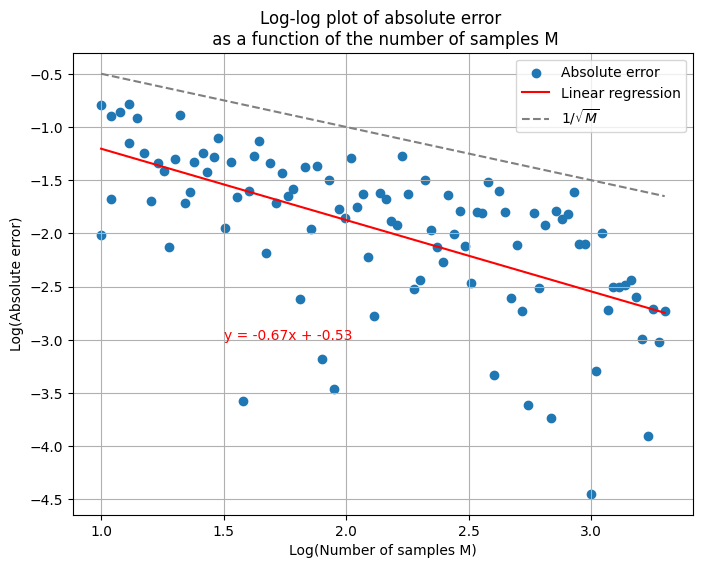

In [5]:
# plot log-log graph to see the order of the error
loglog_graph(nb_samples, CMC_estims, ref_value)

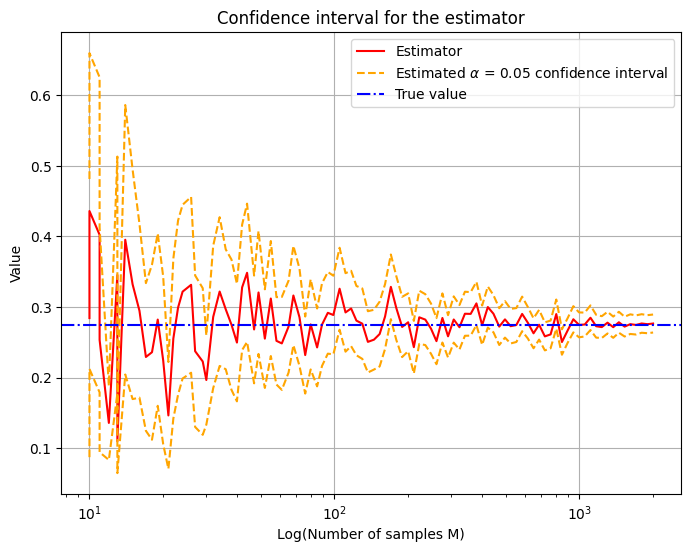

In [6]:
# plot semi-log graph to see the confidence intervals
plot_CI(nb_samples, CMC_estims, CMC_conf, ref_value, alpha)

Plotting the error of the crude Monte Carlo estimator for different values of M (in log-log scale), we observe that it can be approximated by a straight line with slope $\approx 0.5$. We conclude that the error decreases approximately as the square-root of the number of samples M. This is indeed what was expected from a crude Monte Carlo estimator, since it is unbiaised, with variance in $\mathcal{O}(M)$, thus confidence interval in $\mathcal{O}(\sqrt M)$ (from the CLT).

#### b) MCLS
The aim of this second part is to implement the MCLS estimators *$I_{MCLS}$* using an expansion of the Legendre polynomials up to degree n.
We will consider the same values of $M$ (numbers of samples) as in *(a)*, and try different values of $n$ : \
    $n = 10, 20, 30, 50$, \
    $n = \lceil \sqrt M \rceil$, \
    $n = \lceil \frac{M}{2} \rceil$.

In [7]:
# maximum degree of the Legendre polynomials
trials_n = [5, 10, 20, 30, -1, -2]
nb_trials_n = len(trials_n)

# MCLS estimators
MCLS_estims = [-1 * np.ones(N) for _ in range(nb_trials_n)]
MCLS_prime_estims = [-1 * np.ones(N) for _ in range(nb_trials_n)]

# condition number of the Vandermonde matrix
MCLS_cond = [-1 * np.ones(N) for _ in range(nb_trials_n)]
MCLS_prime_cond = [-1 * np.ones(N) for _ in range(nb_trials_n)]

for M in range(N):
    for i in range(nb_trials_n):
        
        n = trials_n[i]

        if n == -1:
            n = np.ceil(np.sqrt(nb_samples[M])).astype(int)
            if nb_samples[M] > 5000: # too computationally expensive
                break
        if n == -2:
            n = np.ceil((nb_samples[M])/2).astype(int)
            if nb_samples[M] > 5000: # too computationally expensive
                break

        if n < nb_samples[M]: # avoid underdetermined least squares
            unif_samps = np.random.uniform(0, 1, nb_samples[M])
            MCLS_estims[i][M], MCLS_cond[i][M], _ = MCLS(unif_samps, f, n)
            MCLS_prime_estims[i][M], MCLS_prime_cond[i][M], _ = MCLS_prime(unif_samps, f, n)

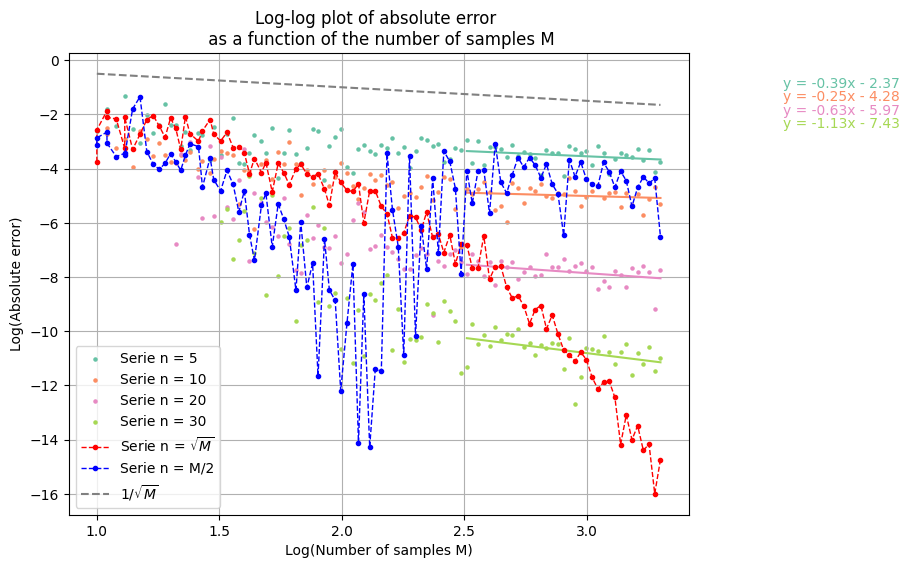

In [8]:
# plot log-log graph to see the order of the error
multiple_loglog_graph(nb_samples, MCLS_estims, ref_value, trials_n)

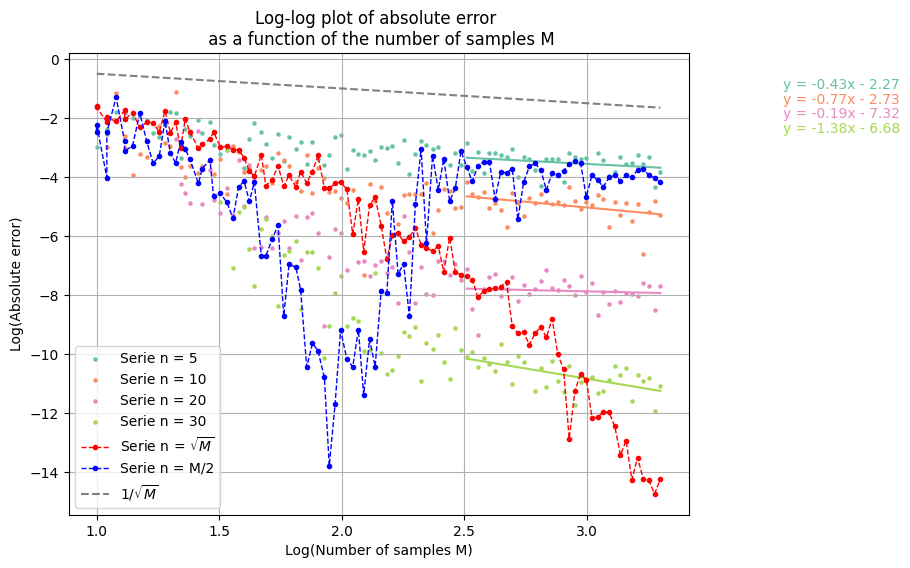

In [9]:
# plot log-log graph to see order of the error
multiple_loglog_graph(nb_samples, MCLS_prime_estims, ref_value, trials_n)

From the plot, we can see that:
- Increasing the polynomial degree $n$ (with $n$ fixed w.r.t. the number of samples $M$) reduces the multiplicative constant. It reduces the error (for each number of samples M, the error is lower for n larger), but it doesn't change the order of convergence.
- If we set $n = \lceil \sqrt M \rceil$, the order of convergence significantly improves. The error is now decreasing faster than $\mathcal{O}(1 / \sqrt{M})$.
- If we set $n = \lceil \frac{M}{2} \rceil$, we distinguish: 
    - an initial phase affected by noise, where the error seems to decrease faster as well, 
    - and a second phase where the error seems to stabilize/decrease, again, as $\mathcal{O}(1 / \sqrt{M})$.

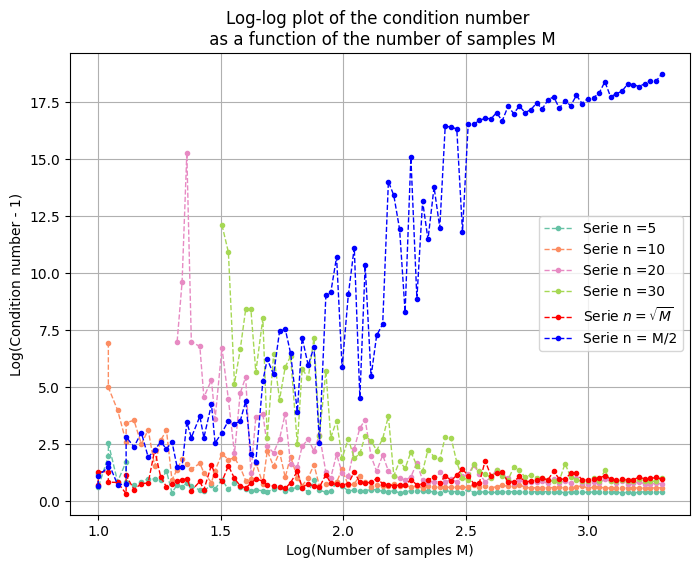

In [10]:
# plot log-log graph to see the evolution of the condition number
multiple_cond_loglog_graph(nb_samples, MCLS_cond, trials_n)

If we choose a value of $n$ too small w.r.t. $M$, the least squares problems becomes very ill-conditioned. If we set $n = \lceil \sqrt M \rceil$, the condition number of the Vandermonde matrix seems to be kept under control. In all these cases, the condition number tends to 1 as $M \to \infty$. Instead, if we set $n = \lceil \frac{M}{2} \rceil$, the condition number explodes as $M$ increases; this might be the reason behind the bad order of convergence of this estimator.

### Question 3
In this question, we propose an expression for $I_{MCLS}$ and $I_{MCLS}'$ generalized to the case of importance sampling. Samples $x^{(i)}$'s are now drawn from a distribution defined by the probability density function $g(x) = \frac{1}{w(x)}$.
We propose: 
$$I_{IS-MCLS} = \frac{\sum_{i=1}^M \left(f(x^{(i)}) - \sum_{j=0}^n c_j^{**} \phi_j(x^{(i)})\right) w(x^{(i)})}{\sum_{i=1}^M w(x^{(i)})} + c_0^{**}$$ 
and 
$$I_{IS-MCLS}' = c_0^{**}$$ 

where $\textbf{c**} = \text{argmin}_{\textbf{c} \in \mathbb{R}^{n+1}} \sum_{i=1}^M w(x^{(i)}) \left(f(x^{(i)}) - \sum_{j=0}^n c_j \phi_j (x^{(i)}) \right)^2$

as generalized estimators IS-MCLS and IS-MCLS'. \
In the LaTeX report, we verify that these verify the properties stated in Question 1 for classical $I_{IS-MCLS}$ and $I_{IS-MCLS}'$ estimators.

### Question 4
- Propose a method to sample from the density $h(x) := \frac{1}{w(x)}$: \
We will be using the Acceptance-rejection method. This method is the one proposed in ref [2], page 6, where we only consider the case where function f has values in $R$ (and not $R^d$). We see 2 possible variations:
    - Method 1: \
    We need a bound on the true propability density function. Knowing that every $\phi_j^2$ can be bounded by $4 e p_1^{\infty}(x)$, $h(x)$ can be bounded by the same quantity. We denote $g(x) = p_1^{\infty}(x) = \frac{1}{\pi \sqrt{x(1-x)}}$ (our bound, without the multiplicative constant).
        1.  Then we sample $Y$ from this bound $g(x)$. Since this bound has a nice expression, this can be done by Inverse transform method.
            We can easily check that the cdf associated to pdf $g(x)$ is: $G(x) = \frac{2}{\pi} \arcsin \sqrt{x}$, and the inverse function is: $G^{-1}(x) = \sin^2(\frac{\pi y}{2})$.
        2.  We sample $U$ from uniform on $[0, 1]$, independant of $Y$.
        3.  If $U \leq \frac{h(Y)}{Cg(Y)} $, set $X=Y$, otherwise return to step 1.
    - Method 2: \
    We note that the function we try to sample from is actually a mixture distribution (i.e., a convex sum of other distributions, with coefficients of the sum summing to 1). Knowing this, we'll use a composition method. Here we decompose our function into each $\phi_i^2$ $i=0,...n$, each of them with a coefficient $\frac{1}{n+1}$.
        1. Composition method: we sample to get a number between $0$ and $n$ to determine which $\phi_i^2$ to sample from.
        2. We sample $Y$ from the bound $g(x)$, $G(x) = \frac{2}{\pi} \arcsin \sqrt{x}$.
        3. We sample $U$ from uniform on $[0, 1]$, independent of $Y$.
        4. If $U \leq \frac{h(Y)}{Cg(Y)} $, set $X=Y$, otherwise return to step 2.
- Implement the MCLS estimators with importance sampling.
- Test on same number of samples as in Question 2. 

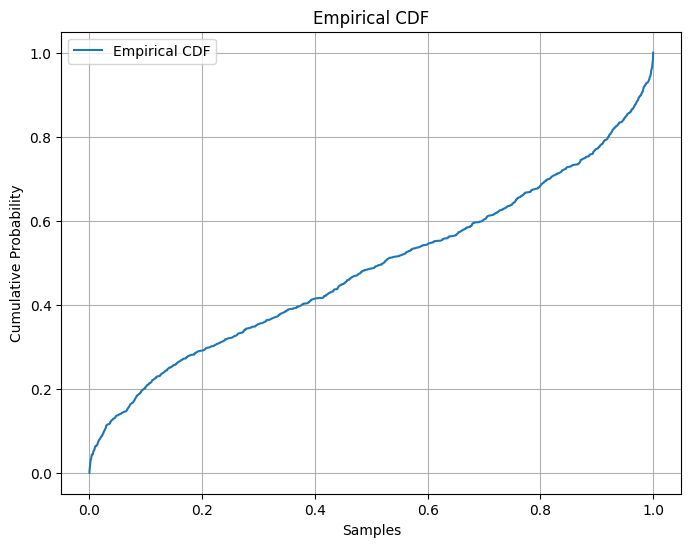

In [11]:
# test sampling from bound g, based on inverse transform method
Y_samples = sample_from_g(1000)
visualize_cdf_from_samples(Y_samples)

Acceptance rate:  0.095428953144384


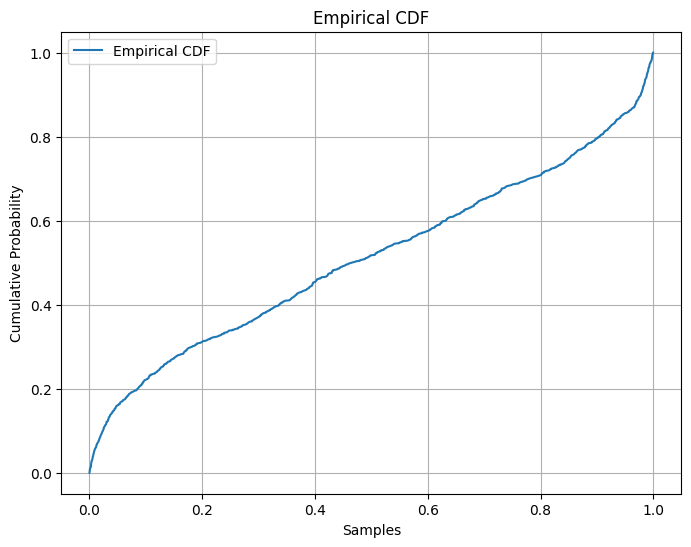

In [12]:
# test sampling from h = 1 / w, done by composition method + AR method
H_samples = sample_from_h(1000, 100, 5, True)
visualize_cdf_from_samples(H_samples)

### Expected pdf and cdf:

<div style="display: flex; flex-direction: row;">
    <img src="Plots/Arcsin_density.png" alt="Image 1" style="width: 50%; height: auto; margin-right: 10px;">
    <img src="Plots/Arcsin_cdf.png" alt="Image 2" style="width: 50%; height: auto;">
</div>

Source: Wikipedia, Arcsine distribution, https://en.wikipedia.org/wiki/Arcsine_distribution

In [15]:
# exact value of the integral (reference)
ref_value = (1/5) * np.arctan(5)

N = 100
nb_samples = np.logspace(np.log10(10), np.log10(2000), num=N, dtype=int) # evenly spaced values on a logarithmic scale

trials_n = [5, 10, 20, -1, -2, -3]
nb_trials_n = len(trials_n)

# MCLS estimators
IS_MCLS_estims = [-1 * np.ones(N) for _ in range(nb_trials_n)]
IS_MCLS_prime_estims = [-1 * np.ones(N) for _ in range(nb_trials_n)]

# condition number of the Vandermonde matrix
IS_MCLS_cond = [-1 * np.ones(N) for _ in range(nb_trials_n)]
IS_MCLS_prime_cond = [-1 * np.ones(N) for _ in range(nb_trials_n)]

tic = time.time()

for M in range(N):
    for i in range(nb_trials_n):

        if (M * nb_trials_n + i) % 50 == 0:
            print(f'Iteration {M * nb_trials_n + i} of {N * nb_trials_n}')
        
        n = trials_n[i]

        if n == -1:
            n = np.ceil(np.sqrt(nb_samples[M])).astype(int)
            if nb_samples[M] > 5000: # too computationally expensive
                break
        if n == -2:
            n = np.ceil((nb_samples[M])/2).astype(int)
            if nb_samples[M] > 5000: # too computationally expensive
                break
        if n == -3:
            n = np.rint(np.real(nb_samples[M] / scipy.special.lambertw(nb_samples[M]))).astype(int)
            if nb_samples[M] > 5000:
                break
        if n == -4:
            n = np.ceil((nb_samples[M])*np.log(nb_samples[M])).astype(int)
            if nb_samples[M] > 5000:
                break

        if n < nb_samples[M]:
            h_samples = sample_from_h(nb_samples[M], 1000, n)
            IS_MCLS_estims[i][M], IS_MCLS_cond[i][M] = IS_MCLS(h_samples, f, n)
            IS_MCLS_prime_estims[i][M], IS_MCLS_prime_cond[i][M] = IS_MCLS_prime(h_samples, f, n)

toc = time.time()
print(f'Elapsed time: {toc - tic}s')

Iteration 0 of 600
Iteration 50 of 600
Iteration 100 of 600
Iteration 150 of 600
Iteration 200 of 600
Iteration 250 of 600
Iteration 300 of 600
Iteration 350 of 600
Iteration 400 of 600
Iteration 450 of 600
Iteration 500 of 600
Iteration 550 of 600
Elapsed time: 4878.506055116653s


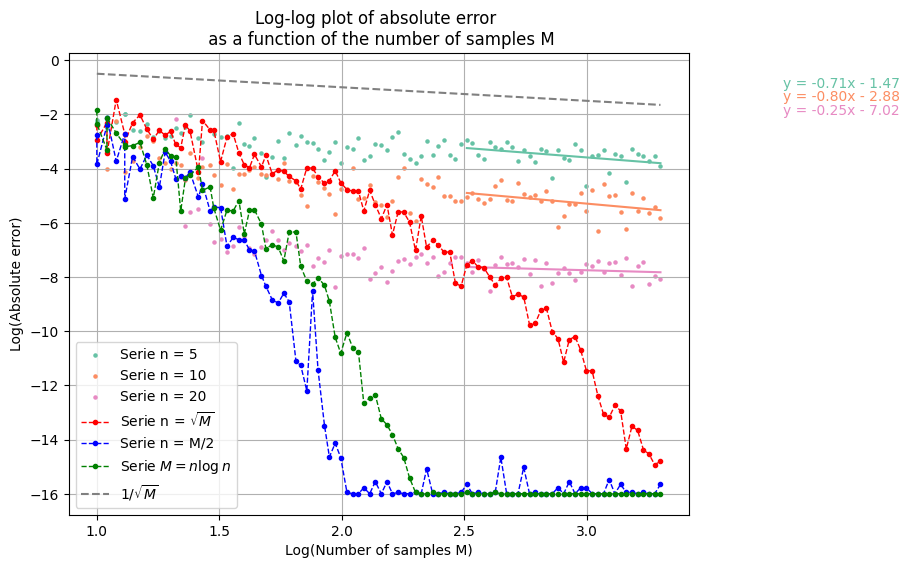

In [16]:
# plot log-log graph to see the order of the error
multiple_loglog_graph(nb_samples, IS_MCLS_estims, ref_value, trials_n)

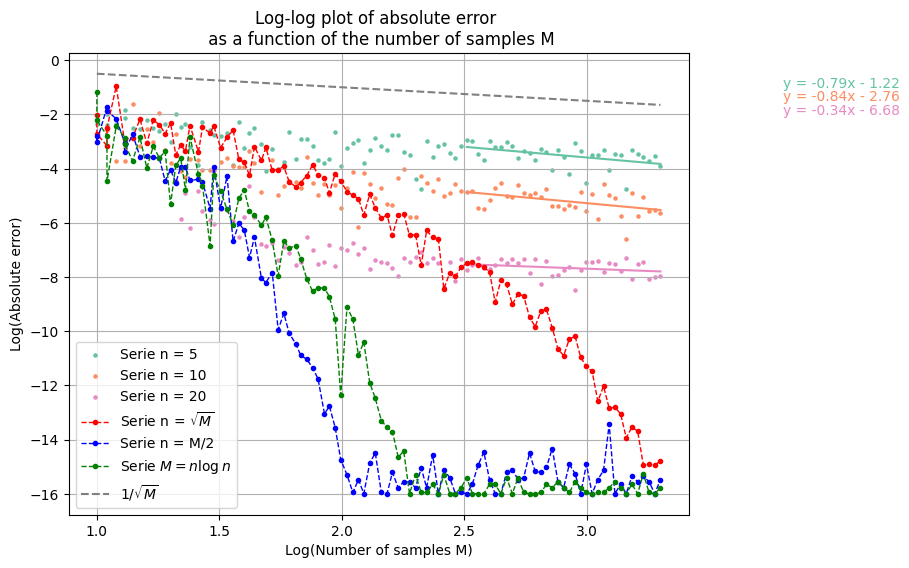

In [18]:
# plot log-log graph to see the order of the error
multiple_loglog_graph(nb_samples, IS_MCLS_prime_estims, ref_value, trials_n)

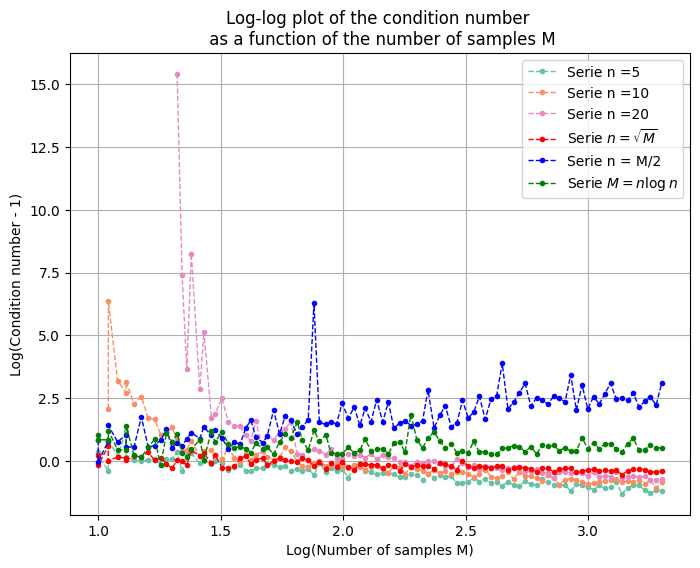

In [19]:
# plot log-log graph to see the evolution of the condition number
multiple_cond_loglog_graph(nb_samples, IS_MCLS_cond, trials_n)

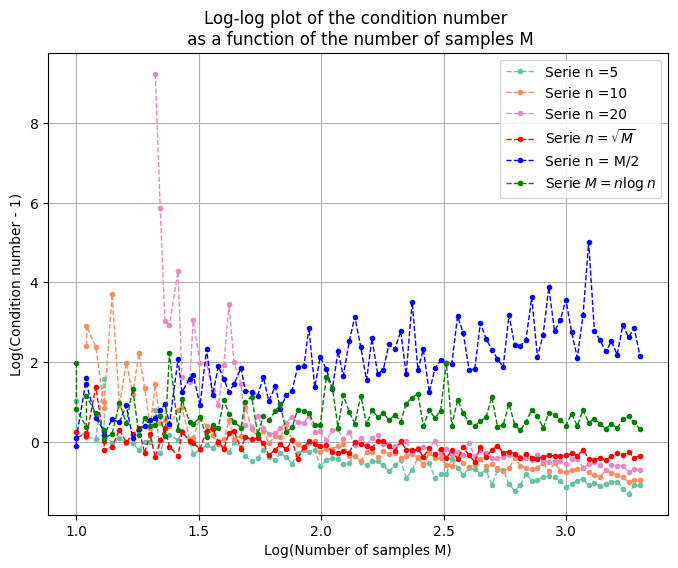

In [20]:
# plot log-log graph to see the evolution of the condition number
multiple_cond_loglog_graph(nb_samples, IS_MCLS_prime_cond, trials_n)

### Question 5
Implementation of the above methods to the FitzHugh-Nagumo system of ODEs. The Fitzhugh–Nagumo model is a bidimensional 
simplification of the Hodgkin-Huxley model, which is used extensively in th field of neuroscience to model the phenomenon of spiking neurons. The system is defined as follows:

\begin{equation}
    \begin{bmatrix}
        \dot v \\
        \dot w \\
    \end{bmatrix}
    =
    \begin{bmatrix}
        v - \frac{v^3}{3} - w + I\\
        \epsilon (v + a - bw)\\
    \end{bmatrix}, \quad
    \begin{bmatrix}
        v (t = 0) \\
        w (t = 0) \\
    \end{bmatrix}
    =
    \begin{bmatrix}
        v^0\\
        w^0\\
    \end{bmatrix}, \quad
    t \in [0, T]
\end{equation}

Here, $v(t)$ and $w(t)$ are the state variables, $\epsilon$ and $I$ are constant values, while $a$ and $b$ are uniformly distributed random parameters: $a\sim \mathcal{U}(0.6,0.8)$ and $b\sim \mathcal{U}(0.7,0.9)$.d

#### Question 5.a

To solve the Fitzhugh-Nagumo system for a fixed pair of parameters $(a,b)$, we discretize the interval $[0, T]$ using a uniform grid with timestep $\Delta t$ and we employ the forward Euler scheme:

\begin{align}
    & v^{n+1} = v^{n} + \Delta t\, \left(v^{n} - \frac{(v^{n})^3}{3} - w^{n} + I\right) && n \in \{ 0,1,...,N_T\}\\
    & w^{n+1} =w^{n} + \Delta t\, \epsilon \left(v^{n} + a - bw^{n}\right) && n \in \{ 0,1,...,N_T\}
\end{align}

In [21]:
# problem data
epsilon = 0.08
I = 1.0
v0 = 0
w0 = 0
t0 = 0
T = 10
Nt = 1000

# uniform sampling of a and b
a = np.random.uniform(0.6, 0.8)
b = np.random.uniform(0.7, 0.9)

v, w, t = solve_FHN(epsilon, I, v0, w0, t0, T, Nt, a, b)
v_scipy, w_scipy, t_scipy = solve_FHN_scipy(epsilon, I, v0, w0, t0, T, Nt, a, b)

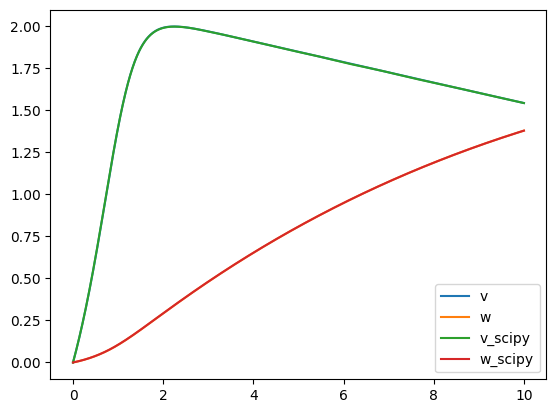

In [22]:
# plot the solution
plt.plot(t, v)
plt.plot(t, w)
plt.plot(t_scipy, v_scipy)
plt.plot(t_scipy, w_scipy)
plt.legend(['v', 'w', 'v_scipy', 'w_scipy'])
plt.show()

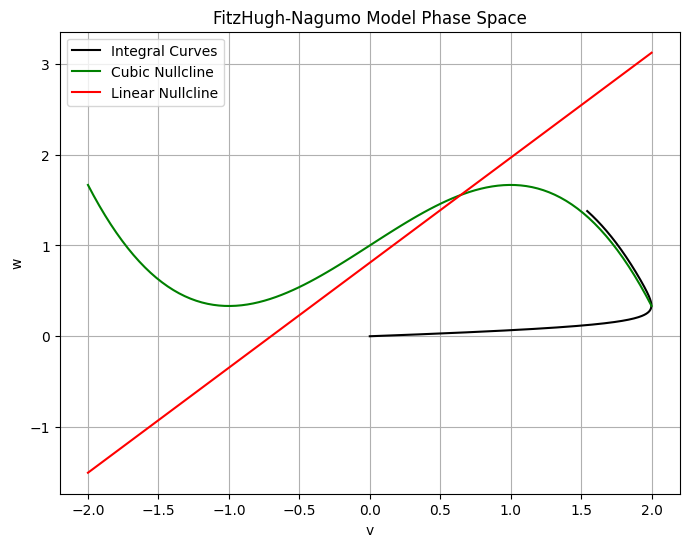

In [23]:
# Plot the phase space
plt.figure(figsize=(8, 6))

# Plot the integral curves 
plt.plot(v, w, 'k-', label='Integral Curves')

# Plot the cubic nullcline 
v_values = np.linspace(-2, 2, 100)
w_values_cubic = v_values - v_values**3 / 3 + I
plt.plot(v_values, w_values_cubic, 'g-', label='Cubic Nullcline')

# Plot the linear nullcline 
w_values_linear = (v_values + a) / b
plt.plot(v_values, w_values_linear, 'r-', label='Linear Nullcline')

# Set labels and title
plt.xlabel('v')
plt.ylabel('w')
plt.title('FitzHugh-Nagumo Model Phase Space')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

#### Question 5.b

We then consider the Quantity of Interest (QoI):

\begin{equation}
    \frac{1}{T}\int_0^T v^2(t)dt\approx \sum_{n=0}^{N_T-1}\left(\frac{(v^n)^2+(v^{n+1})^2}{2}\right)\Delta t=: Q
\end{equation}

Our goal is to implement the CMC and MCLS estimators to compute the following integral:

\begin{equation}
    I_2=\int_{0.6}^{0.8}\int_{0.7}^{0.9} Q da db
\end{equation}

To do so, we need to adapt the estimators to the 2D case (detailed in the LaTex report).

In [24]:
compute_ref = False

# compute a reference value for CMC by using high number of sample points
# WARNING: it takes a long time to run
if compute_ref:
    N = int(1e5)
    a_unif = np.random.uniform(0.6, 0.8, N)
    b_unif = np.random.uniform(0.7, 0.9, N)
    ref_value_2D = crude_MC_2D(a_unif, b_unif, epsilon, I, v0, w0, t0, T, Nt)

In [25]:
# REFERENCE VALUE
ref_value_2D = 1.174996467515269

In [26]:
N = 100
nb_samples = np.logspace(np.log10(10), np.log10(1000), num=N, dtype=int) # evenly spaced values on a logarithmic scale

# crude Monte Carlo estimator
CMC_estims = np.zeros(N)

# confidence interval
alpha = 0.05
CMC_conf = np.zeros((N, 2))

for M in range(N):
    a_samples = np.random.uniform(0.6, 0.8, nb_samples[M])
    b_samples = np.random.uniform(0.7, 0.9, nb_samples[M])
    CMC_estims[M], CMC_conf[M] = crude_MC_2D(a_samples, b_samples, epsilon, I, v0, w0, t0, T, Nt, alpha)

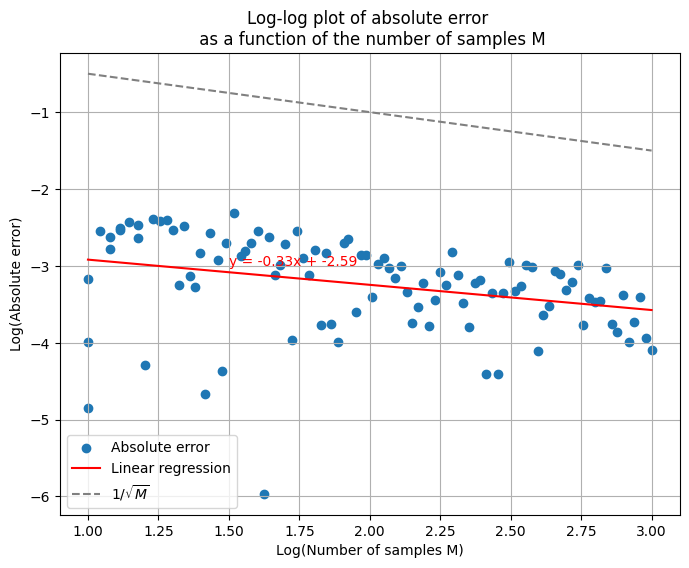

In [27]:
# plot log-log graph to see the order of the error
loglog_graph(nb_samples, CMC_estims, ref_value_2D)

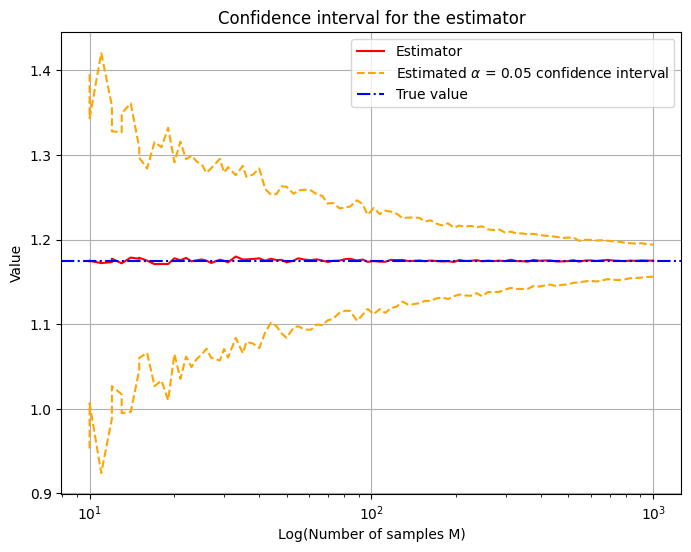

In [28]:
# plot semi-log graph to see the confidence intervals
plot_CI(nb_samples, CMC_estims, CMC_conf, ref_value_2D, alpha)

In [29]:
# compute a reference value for MCLS by using high number of sample points
# WARNING: it takes a long time to run
if compute_ref:
    N = int(1e4)
    n = 3
    a_unif = np.random.uniform(0.6, 0.8, N)
    b_unif = np.random.uniform(0.7, 0.9, N)
    ref_value_2D_MCLS, _, _ = MCLS_2D(a_unif, b_unif, n, epsilon, I, v0, w0, t0, T, Nt)
    ref_value_2D_MCLS_prime, _, _ = MCLS_prime_2D(a_unif, b_unif, n, epsilon, I, v0, w0, t0, T, Nt)

In [30]:
# REFERENCE VALUES
ref_value_2D_MCLS = 1.1749791860591807
ref_value_2D_MCLS_prime = 1.174979186071431

In [31]:
# maximum degree of the Legendre polynomials
trials_n = [0, 1, 2, 3]
nb_trials_n = len(trials_n)

# MCLS estimators
MCLS_estims_2D = [-1 * np.ones(N) for _ in range(nb_trials_n)]
MCLS_prime_estims_2D = [-1 * np.ones(N) for _ in range(nb_trials_n)]

# confidence intervals
alpha = 0.05
MCLS_CI_2D = [-1 * np.ones((N,2)) for _ in range(nb_trials_n)]

# error estimators
err_MCLS_2D = [-1 * np.ones(N) for _ in range(nb_trials_n)]

tic = time.time()

for M in range(N):
    for i in range(nb_trials_n):

        if (M * nb_trials_n + i) % 10 == 0:
            print(f'Iteration {M * nb_trials_n + i} of {N * nb_trials_n}')
        
        n = trials_n[i]

        if n < nb_samples[M]:
            a_unif_samps = np.random.uniform(0.6, 0.8, nb_samples[M])
            b_unif_samps = np.random.uniform(0.7, 0.9, nb_samples[M])
            MCLS_estims_2D[i][M], _, MCLS_CI_2D[i][M]= MCLS_2D(a_unif_samps, b_unif_samps, n, epsilon, I, v0, w0, t0, T, Nt, alpha)
            err_MCLS_2D[i][M] = calculate_error(a_unif_samps, b_unif_samps, n, epsilon, I, v0, w0, t0, T, Nt)
            MCLS_prime_estims_2D[i][M], _, _ = MCLS_prime_2D(a_unif_samps, b_unif_samps, n, epsilon, I, v0, w0, t0, T, Nt)

toc = time.time()
print(f'Elapsed time: {toc - tic}s')

Iteration 0 of 400
Iteration 10 of 400
Iteration 20 of 400
Iteration 30 of 400
Iteration 40 of 400
Iteration 50 of 400
Iteration 60 of 400
Iteration 70 of 400
Iteration 80 of 400
Iteration 90 of 400
Iteration 100 of 400
Iteration 110 of 400
Iteration 120 of 400
Iteration 130 of 400
Iteration 140 of 400
Iteration 150 of 400
Iteration 160 of 400
Iteration 170 of 400
Iteration 180 of 400
Iteration 190 of 400
Iteration 200 of 400
Iteration 210 of 400
Iteration 220 of 400
Iteration 230 of 400
Iteration 240 of 400
Iteration 250 of 400
Iteration 260 of 400
Iteration 270 of 400
Iteration 280 of 400
Iteration 290 of 400
Iteration 300 of 400
Iteration 310 of 400
Iteration 320 of 400
Iteration 330 of 400
Iteration 340 of 400
Iteration 350 of 400
Iteration 360 of 400
Iteration 370 of 400
Iteration 380 of 400
Iteration 390 of 400
Elapsed time: 1038.951263666153s


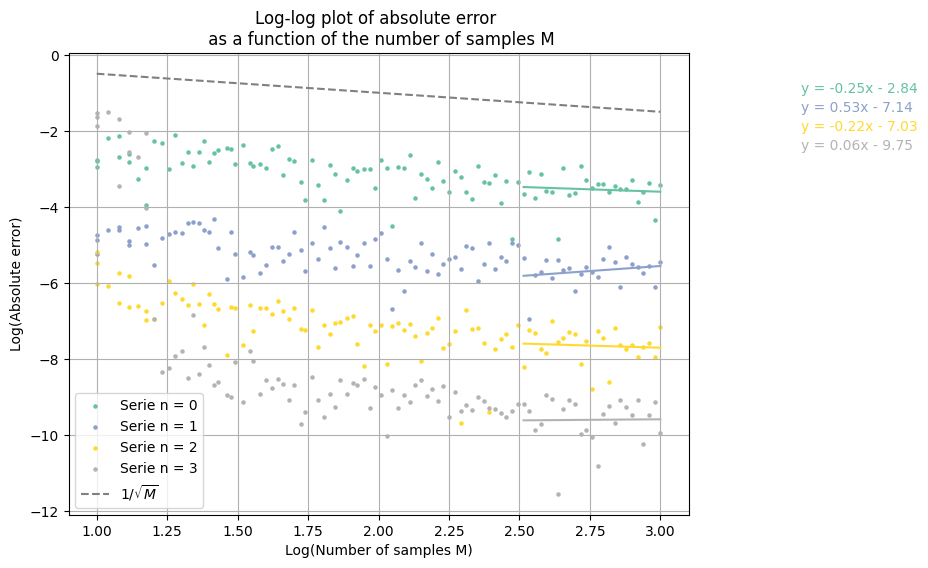

In [32]:
# plot log-log graph to see the order of the error
multiple_loglog_graph(nb_samples, MCLS_estims_2D, ref_value_2D_MCLS, trials_n)

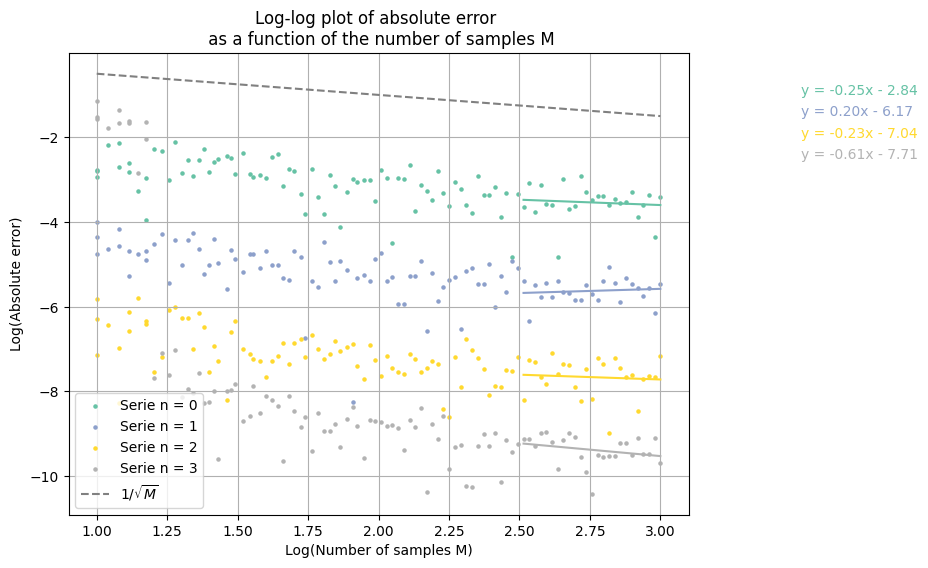

In [33]:
# plot log-log graph to see the order of the error
multiple_loglog_graph(nb_samples, MCLS_prime_estims_2D, ref_value_2D_MCLS_prime, trials_n)

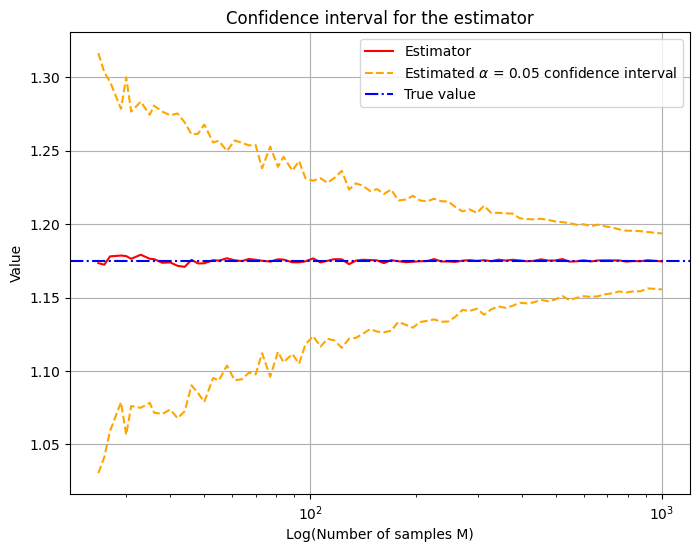

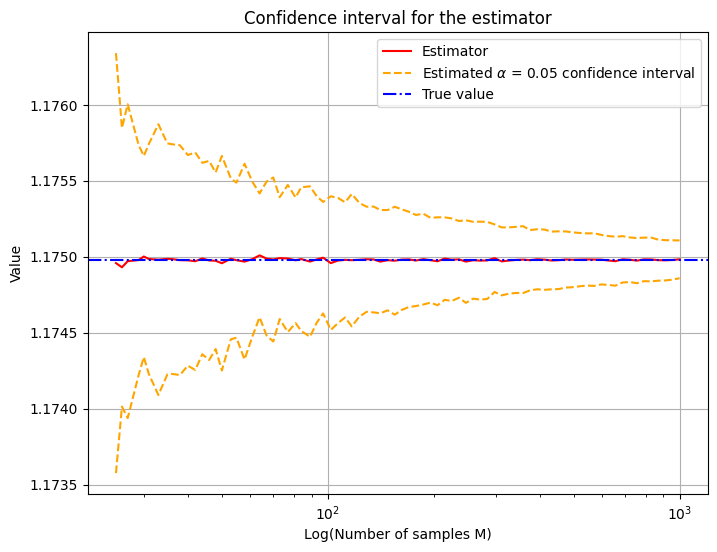

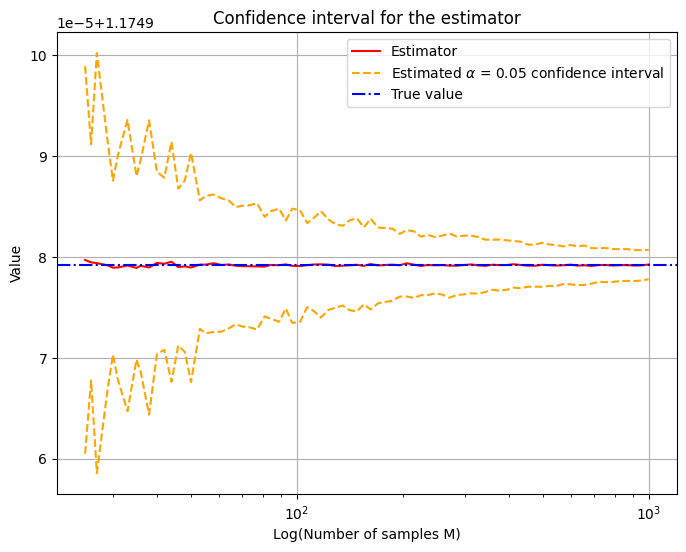

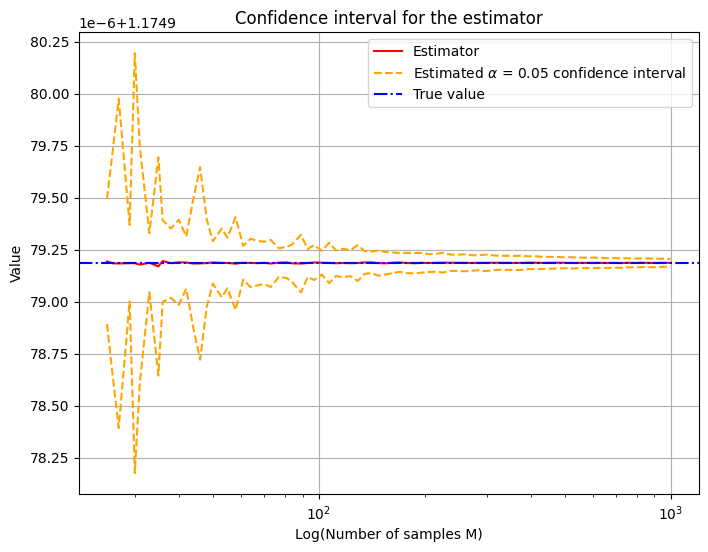

In [34]:
# plot the confidence interval for a fixed n
cut = 20
for i in range(nb_trials_n):
    plot_CI(nb_samples[cut:], MCLS_estims_2D[i][cut:], MCLS_CI_2D[i][cut:], ref_value_2D_MCLS, alpha)

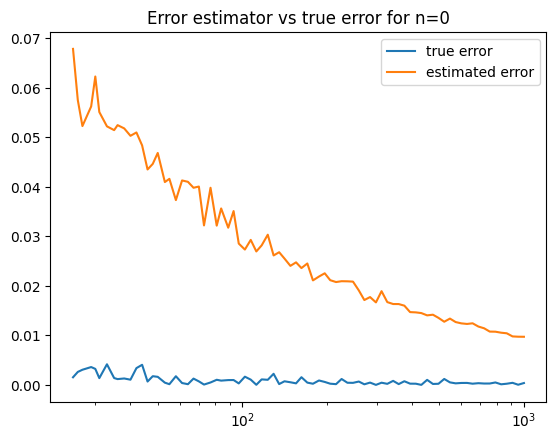

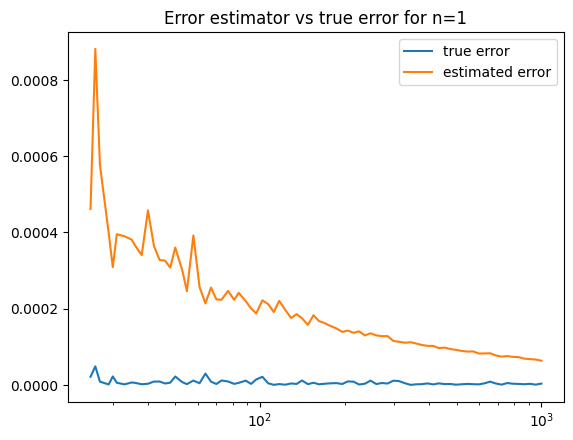

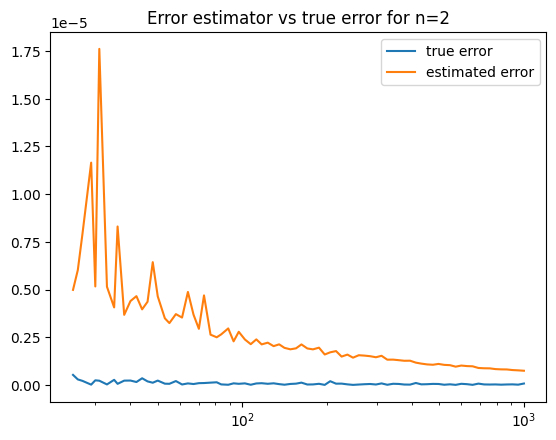

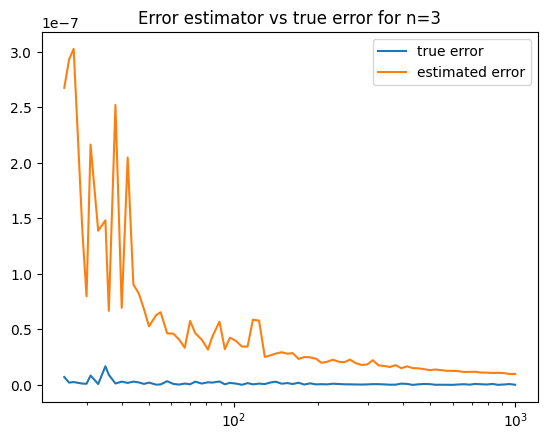

In [35]:
# plot the error estimator vs the true error
cut = 20
plt.figure()
for i in range(nb_trials_n):
    plt.plot(nb_samples[cut:], np.abs(MCLS_estims_2D[i][cut:] - ref_value_2D_MCLS), label=f'true n={trials_n[i]}')
    plt.plot(nb_samples[cut:], err_MCLS_2D[i][cut:], label=f'estimated n={trials_n[i]}')
    plt.title('Error estimator vs true error for n=' + str(trials_n[i]))
    plt.xscale('log')
    plt.legend(['true error', 'estimated error'])
    plt.show()